In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns
import os

from sklearn.datasets import fetch_covtype
import torchvision
import torchvision.transforms as transforms
import torch

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tqdm
from baselineClassifierNN import SimpleMLP
from DynamicClassifierNN import DynamicMLP

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from itertools import product


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
rcParams['axes.labelsize'] = 12  # Academic font size for axis labels
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['axes.titlesize'] = 14
figsize = (8, 6) 

In [3]:
data_dir = "../data"
results_dir = "../results"

# Get datasets section

### Covtype dataset

In [4]:
data_cov = fetch_covtype(as_frame=True)
df_covtype = data_cov.frame 

df_covtype['Cover_Type'] = df_covtype['Cover_Type'] - 1
df_covtype['Aspect_sin'] = np.sin(np.deg2rad(df_covtype['Aspect']))
df_covtype['Aspect_cos'] = np.cos(np.deg2rad(df_covtype['Aspect']))
df_covtype = df_covtype.drop(columns=['Aspect'])


X_cov_type = df_covtype.drop('Cover_Type', axis=1).values
y_cov_type = df_covtype['Cover_Type'].values

print("Covtype dataset loaded.")
print(f"Covtype features shape: {X_cov_type.shape}, Covtype labels shape: {y_cov_type.shape}")

Covtype dataset loaded.
Covtype features shape: (581012, 55), Covtype labels shape: (581012,)


In [5]:
df_covtype.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Aspect_sin,Aspect_cos
0,2596.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.777146,0.629320
1,2590.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.829038,0.559193
2,2804.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.656059,-0.754710
3,2785.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.422618,-0.906308
4,2595.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.707107,0.707107


### Fashion-MNIST dataset

In [6]:

# Download and load Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True,  
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Convert train_dataset to DataFrame
train_images = []
train_labels = []

for img, label in train_dataset:
    train_images.append(img.numpy().flatten())
    train_labels.append(label)

df_train_fashion = pd.DataFrame(train_images)
df_train_fashion['label'] = train_labels

# Convert test_dataset to DataFrame
test_images = []
test_labels = []

for img, label in test_dataset:
    test_images.append(img.numpy().flatten())
    test_labels.append(label)

df_test_fashion = pd.DataFrame(test_images)
df_test_fashion['label'] = test_labels

print("Fashion-MNIST dataset loaded.")
print(f"Fashion-MNIST train shape: {df_train_fashion.shape}, Fashion-MNIST test shape: {df_test_fashion.shape}")
df_train_fashion.head()


Fashion-MNIST dataset loaded.
Fashion-MNIST train shape: (60000, 785), Fashion-MNIST test shape: (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# what is the class distribution for each dataset
print("Covtype class distribution:\n", pd.Series(y_cov_type).value_counts().sort_index())
print("Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Covtype class distribution:
 0    211840
1    283301
2     35754
3      2747
4      9493
5     17367
6     20510
Name: count, dtype: int64
Fashion-MNIST class distribution:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


In [8]:
# take away 1000 entries from class label 0 in fashion mnist
for i in range(0, 10):
    index_to_drop = df_train_fashion[df_train_fashion['label'] == i].index[0]
    df_train_fashion = df_train_fashion.drop(df_train_fashion[df_train_fashion['label'] == i].index[:500*i])
print("Updated Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Updated Fashion-MNIST class distribution:
 label
0    6000
1    5500
2    5000
3    4500
4    4000
5    3500
6    3000
7    2500
8    2000
9    1500
Name: count, dtype: int64


### Prepare each dataset for training and testing

### Covtype dataset

In [9]:

X_train_cov_init, X_test_cov_init, y_train_cov_init, y_test_cov_init = train_test_split(X_cov_type, y_cov_type, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_cov_scaled = scaler.fit_transform(X_train_cov_init)
X_test_cov_scaled = scaler.transform(X_test_cov_init)

X_train_cov = torch.tensor(X_train_cov_scaled, dtype=torch.float32).to(device)
X_test_cov = torch.tensor(X_test_cov_scaled, dtype=torch.float32).to(device)
# need to minus 1 to make labels start from 0
y_train_cov = torch.tensor((y_train_cov_init), dtype=torch.long).to(device)
y_test_cov = torch.tensor((y_test_cov_init), dtype=torch.long).to(device)
print("Min label:", y_train_cov.min().item(), "Max label:", y_train_cov.max().item())

Min label: 0 Max label: 6


### Fashion-MNIST dataset

In [10]:
X_train_fashion_init = df_train_fashion.drop('label', axis=1)
y_train_fashion = df_train_fashion['label']

X_test_fashion_init = df_test_fashion.drop('label', axis=1)
y_test_fashion = df_test_fashion['label']

X_train_fashion = torch.tensor(X_train_fashion_init.values, dtype=torch.float32).to(device)
y_train_fashion = torch.tensor(y_train_fashion.values, dtype=torch.long).to(device)
X_test_fashion = torch.tensor(X_test_fashion_init.values, dtype=torch.float32).to(device)
y_test_fashion = torch.tensor(y_test_fashion.values, dtype=torch.long).to(device)

### train baseline model

In [11]:
# 'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64), (150, 100, 50, 25)]
param_grid = {
    'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64),
        (200, 150, 100, 50),
        (256, 128, 64, 32),     
        (512, 256, 128, 64),  
        (128, 128, 128, 128),     
        (300, 200, 100, 50),  ],
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [300]
}

In [12]:
def grid_search_params(X_train, y_train, X_test, y_test, param_grid):
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train))

    results = []

    for hidden_layers, activation, lr, epochs in product(
        param_grid['hidden_layers'],
        param_grid['activation'],
        param_grid['lr'],
        param_grid['epochs']
    ):
        model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr) if activation == 'relu' else optim.SGD(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_test).argmax(dim=1)
            acc = accuracy_score(y_test.cpu(), preds.cpu())
        results.append({
            'hidden_layers': hidden_layers,
            'activation': activation,
            'lr': lr,
            'epochs': epochs,
            'accuracy': acc
        })

    # Display top 5 results
    results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
    print(results_df.head())

In [13]:
# grid_search_params(X_train_cov, y_train_cov, X_test_cov, y_test_cov, param_grid)

In [14]:
# grid_search_params(X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion, param_grid)

In [15]:
optimal_params_cov = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.01,
}
optimal_params_fashion = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.005,

}

### baseline model training and evaluation ###

In [16]:
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=50):
    train_acc = []
    test_acc = []
    for epoch in tqdm.tqdm(range(epochs), desc="Training Progress"):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Training accuracy
        model.eval()
        with torch.no_grad():
            train_preds = model(X_train).argmax(dim=1)
            test_preds = model(X_test).argmax(dim=1)
            train_acc.append(accuracy_score(y_train.cpu(), train_preds.cpu()))
            test_acc.append(accuracy_score(y_test.cpu(), test_preds.cpu()))
    return train_acc, test_acc

def plot_learning_curves(train_acc, test_acc, title="Learning Curves"):
    plt.figure(figsize=figsize)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#### covtype model training and evaluation

Training Progress:   0%|          | 0/400 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 400/400 [05:06<00:00,  1.30it/s]


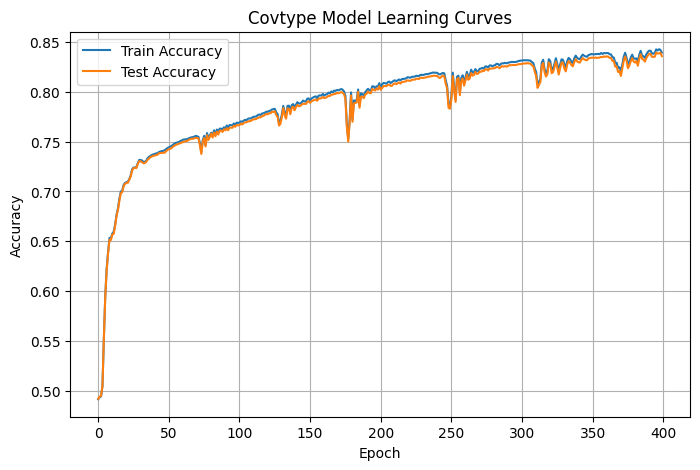

In [68]:
input_dim_cov = X_train_cov.shape[1]
output_dim_cov = len(torch.unique(y_train_cov))
hidden_layers_cov = optimal_params_cov['hidden_layers']
activation_cov = optimal_params_cov['activation']

model_cov = SimpleMLP(input_dim_cov, hidden_layers_cov, output_dim_cov, activation_cov).to(device)
optimizer_cov = torch.optim.Adam(model_cov.parameters(), lr=optimal_params_cov['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_model(model_cov, optimizer_cov, criterion, X_train_cov, y_train_cov, X_test_cov, y_test_cov, epochs=400)
plot_learning_curves(train_acc, test_acc, title="Covtype Model Learning Curves")

#### fashion-mnist training and evaluation

Training Progress: 100%|██████████| 400/400 [01:59<00:00,  3.34it/s]


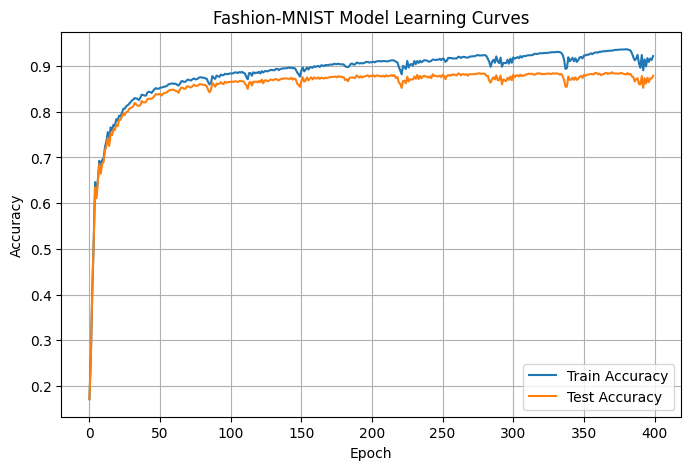

In [69]:
input_dim_fashion = X_train_fashion.shape[1]
output_dim_fashion = len(torch.unique(y_train_fashion))
hidden_layers_fashion = optimal_params_fashion['hidden_layers']
activation_fashion = optimal_params_fashion['activation']

model_fashion = SimpleMLP(input_dim_fashion, hidden_layers_fashion, output_dim_fashion, activation_fashion).to(device)
optimizer_fashion = torch.optim.Adam(model_fashion.parameters(), lr=optimal_params_fashion['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_model(model_fashion, optimizer_fashion, criterion, X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion, epochs=400)
plot_learning_curves(train_acc, test_acc, title="Fashion-MNIST Model Learning Curves")

### training for dynamic model

In [121]:
# # Concatenate vertically (stack rows)
# combined_df = pd.concat([df1, df2], axis=0)


In [18]:
dfs_cov = [df_covtype[df_covtype['Cover_Type'] == i] for i in range(7)]
dfs_fashion = [df_train_fashion[df_train_fashion['label'] == i] for i in range(10)]

print("DataFrames split by class created.")

DataFrames split by class created.


In [19]:
# sort the dataframes list by the size of each dataframe in ascending order
dfs_cov.sort(key=lambda x: len(x), reverse=True)
dfs_fashion.sort(key=lambda x: len(x), reverse=True)

print("DataFrames sorted by class size.")
print(f"Size of each class in Covtype: {[len(df) for df in dfs_cov]}")

DataFrames sorted by class size.
Size of each class in Covtype: [283301, 211840, 35754, 20510, 17367, 9493, 2747]


In [17]:
def train_complex_model(model, optimizer, criterion, parameters, all_train_dfs, all_test_dfs, label, epochs=50):
    train_acc = []
    test_acc = []
    look_back = 20

    has_underfit = False
    has_overfit = False
    has_plateaued = False
    lock = False
    lock_epochs = 0

    X_train, y_train, X_test, y_test = None, None, None, None
    current_class_index = 2  # start from the third class since first two are combined initially
    def combine_new_class_to_dataset(new_class_df_train, new_class_df_test):
        nonlocal X_train, y_train, X_test, y_test
        if X_train is None or y_train is None:
            combined_train_df = new_class_df_train
            combined_test_df = new_class_df_test
        else:
            combined_train_df = pd.concat([pd.DataFrame(X_train.cpu().numpy()), pd.DataFrame(y_train.cpu().numpy(), columns=[label]), new_class_df_train], axis=0).sample(frac=1).reset_index(drop=True)
            combined_test_df = pd.concat([pd.DataFrame(X_test.cpu().numpy()), pd.DataFrame(y_test.cpu().numpy(), columns=[label]), new_class_df_test], axis=0).sample(frac=1).reset_index(drop=True)

        X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
        y_train = torch.tensor(combined_train_df[label].values if label in combined_train_df else combined_train_df['label'].values, dtype=torch.long).to(device)

        X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
        y_test = torch.tensor(combined_test_df[label].values if label in combined_test_df else combined_test_df['label'].values, dtype=torch.long).to(device)

    # start with the first 2 dataframes
    if len(all_train_dfs) >= 2:
        combined_train_df = pd.concat(all_train_dfs[:2], axis=0).sample(frac=1).reset_index(drop=True)
        combined_test_df = pd.concat(all_test_dfs[:2], axis=0).sample(frac=1).reset_index(drop=True)

        X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
        y_train = torch.tensor(combined_train_df[label].values if label in combined_train_df else combined_train_df['label'].values, dtype=torch.long).to(device)

        X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
        y_test = torch.tensor(combined_test_df[label].values if label in combined_test_df else combined_test_df['label'].values, dtype=torch.long).to(device)

    for epoch in tqdm.tqdm(range(epochs), desc="Training Progress"):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Training accuracy
        model.eval()
        with torch.no_grad():
            train_preds = model(X_train).argmax(dim=1)
            test_preds = model(X_test).argmax(dim=1)
            train_acc.append(accuracy_score(y_train.cpu(), train_preds.cpu()))
            test_acc.append(accuracy_score(y_test.cpu(), test_preds.cpu()))

        if epoch > look_back and not lock:
            recent_train_acc = train_acc[-look_back:]
            recent_test_acc = test_acc[-look_back:]

            train_trend = np.polyfit(range(look_back), recent_train_acc, 1)[0]
            test_trend = np.polyfit(range(look_back), recent_test_acc, 1)[0]

            if train_trend < 0.005 and test_trend < 0.005:
                has_plateaued = True
                print(f"Training has plateaued at epoch {epoch}.")
                if current_class_index == len(all_train_dfs):
                    print("All classes have been added. Cannot add more classes.")
                    return train_acc, test_acc
                
                
            # check if underfitting
            elif train_trend > 0.001 and test_trend > 0.001:
                has_underfit = True
                print("Model is underfit at epoch: ", epoch)
                model.add_hidden_layer() 
                optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
                current_class_index += 1

            # check if overfitting
            elif train_trend > 0.01 and test_trend < -0.01:
                has_overfit = True
                print("Model is overfit at epoch: ", epoch)
                if current_class_index < len(all_train_dfs):
                    print(f"Adding new class {current_class_index} to the dataset.")
                    combine_new_class_to_dataset(all_train_dfs[current_class_index], all_test_dfs[current_class_index])
                    model.update_output_layer(len(torch.unique(y_train)))
                    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
                else: 
                    print("All classes have been added. Cannot add more classes.")
                    return train_acc, test_acc

            # if any of the flags are set, lock further checks
            if has_underfit or has_overfit or has_plateaued:
                lock = True
                lock_epochs = 10
                print("Locking further checks for 10 epochs.")
        else:
            if lock:
                lock_epochs -= 1
                if lock_epochs <= 0:
                    lock = False
                    print("Unlocking checks after lock period.")
        
        # reset flags for next epoch
        has_underfit = False
        has_overfit = False
        has_plateaued = False

    print("Training completed early - needs further tuning.")
    return train_acc, test_acc
 

In [ ]:
FIX THE DATASETS NOW

input_dim_cov = X_train_cov.shape[1]
activation_cov = optimal_params_cov['activation']
model_cov_dynamic = DynamicMLP(input_dim_cov).to(device)
optimizer_cov_dynamic = torch.optim.Adam(model_cov_dynamic.parameters(), lr=optimal_params_cov['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_complex_model(model_cov_dynamic, optimizer_cov_dynamic, criterion, optimal_params_cov, dfs_cov, dfs_cov, 'Cover_Type', epochs=400)
plot_learning_curves(train_acc, test_acc, title="Dynamic Covtype Model Learning Curves")

NameError: name 'dfs_cov' is not defined